In [ ]:
!kaggle competitions download -c playground-series-s4e1

In [ ]:
!mkdir data && tar -xf playground-series-s4e1.zip -C data

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/test.csv
data/train.csv
data/sample_submission.csv


In [124]:
import torch

df = pd.read_csv("data/train.csv")

---
# Exploratory Data Analysis (EDA):

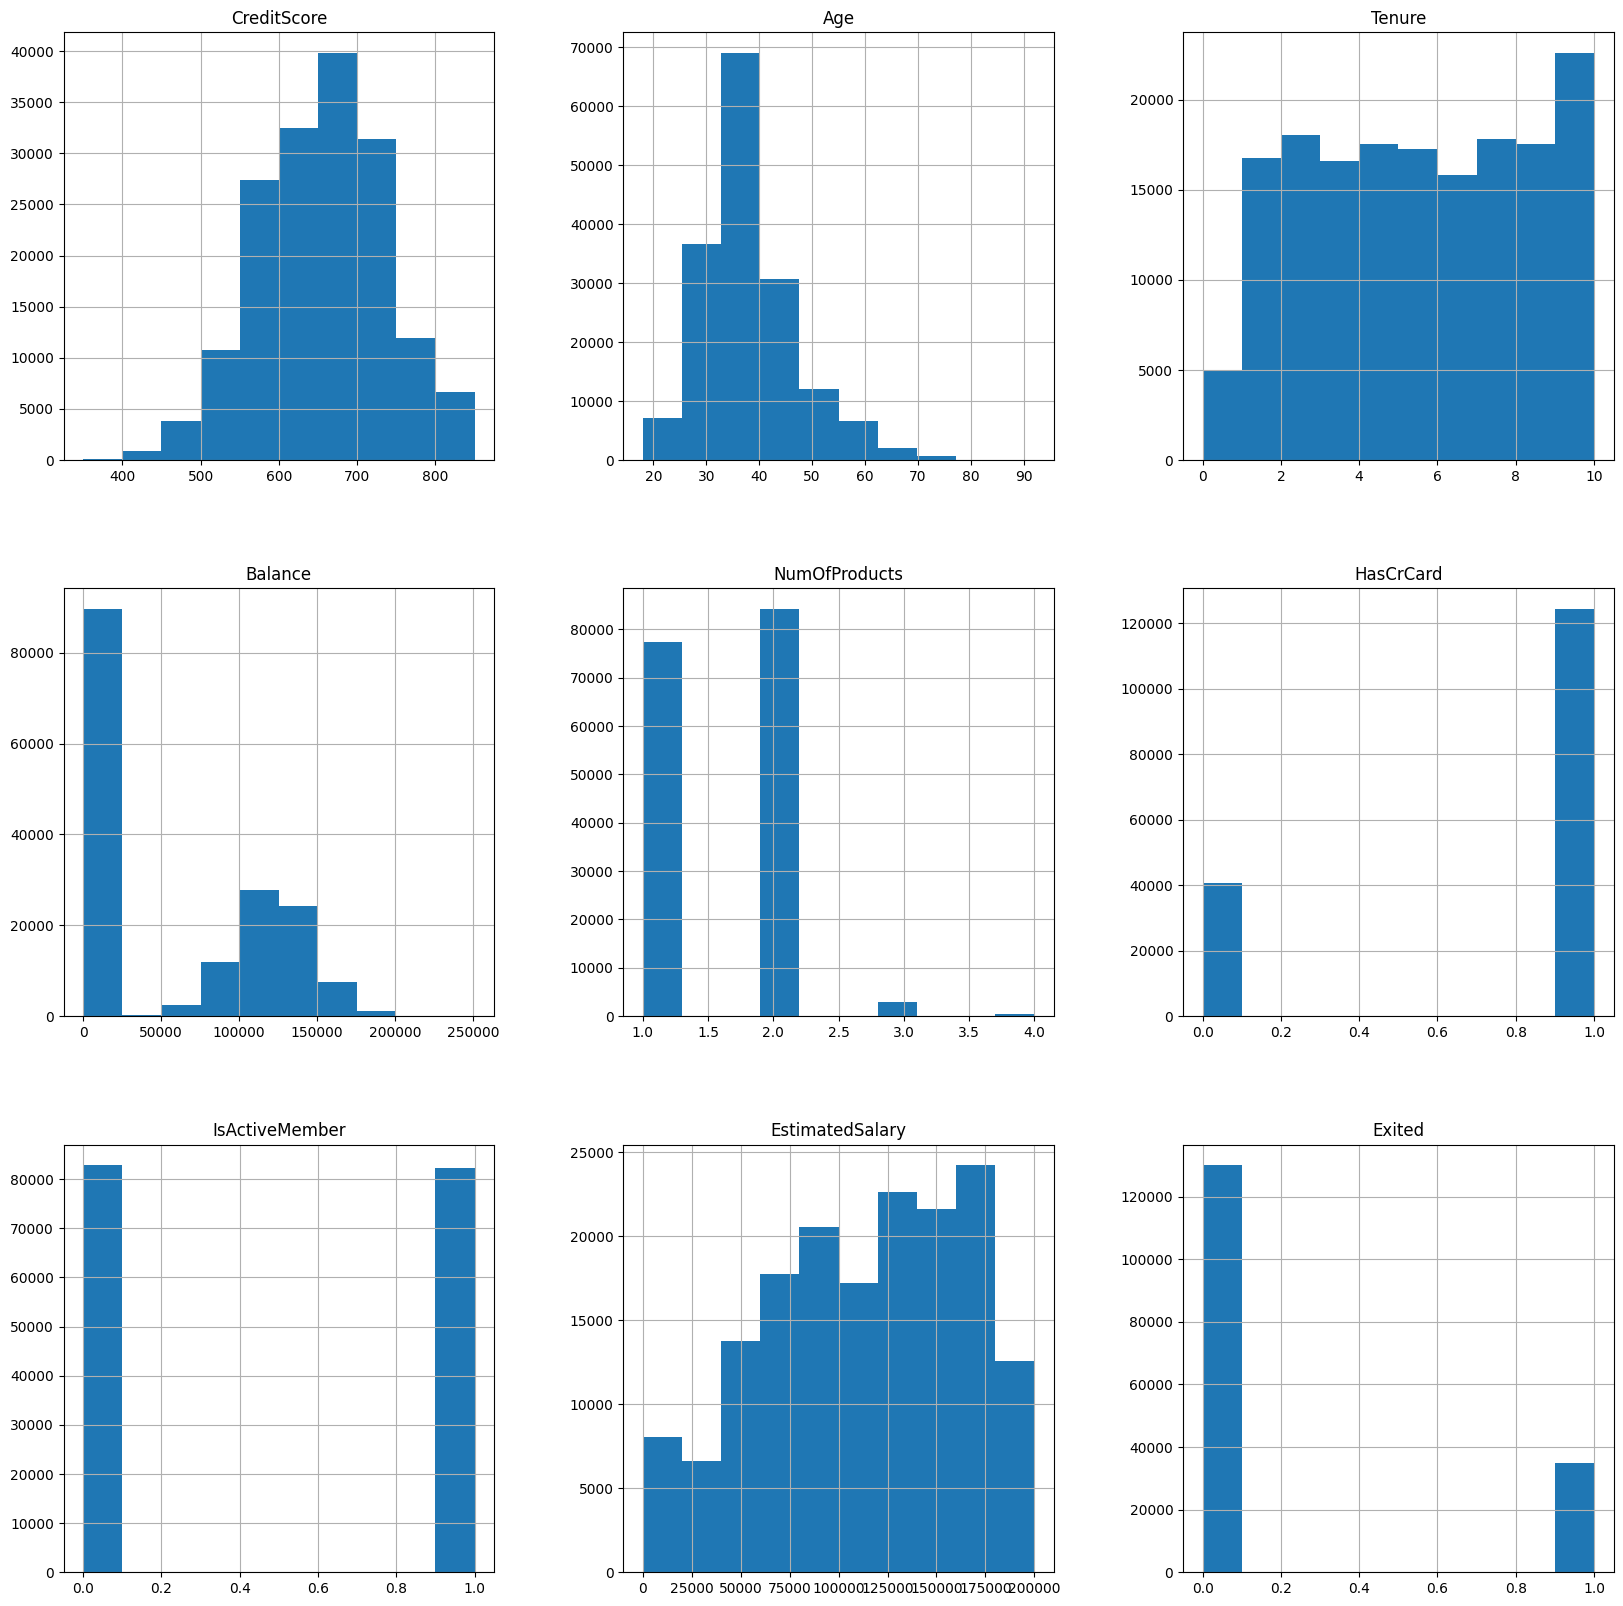

In [70]:
df.drop(['Surname', 'id', 'CustomerId'], axis=1).hist(figsize=(20,20))
plt.show()

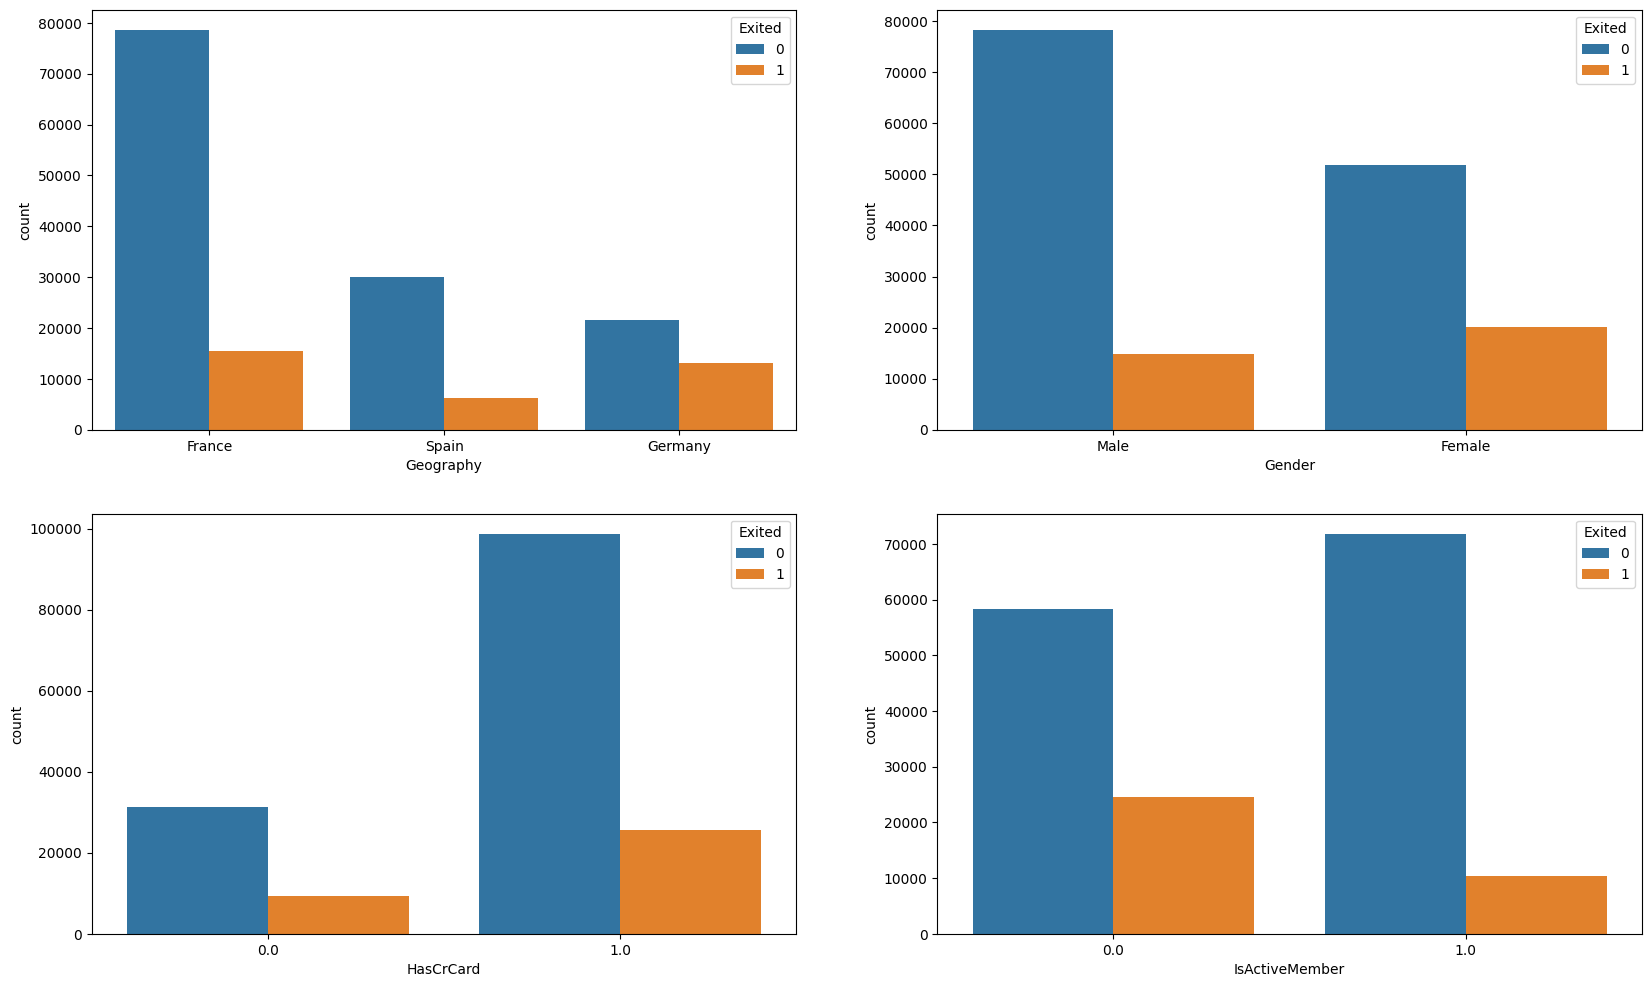

In [82]:

import seaborn as sns

fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1]);

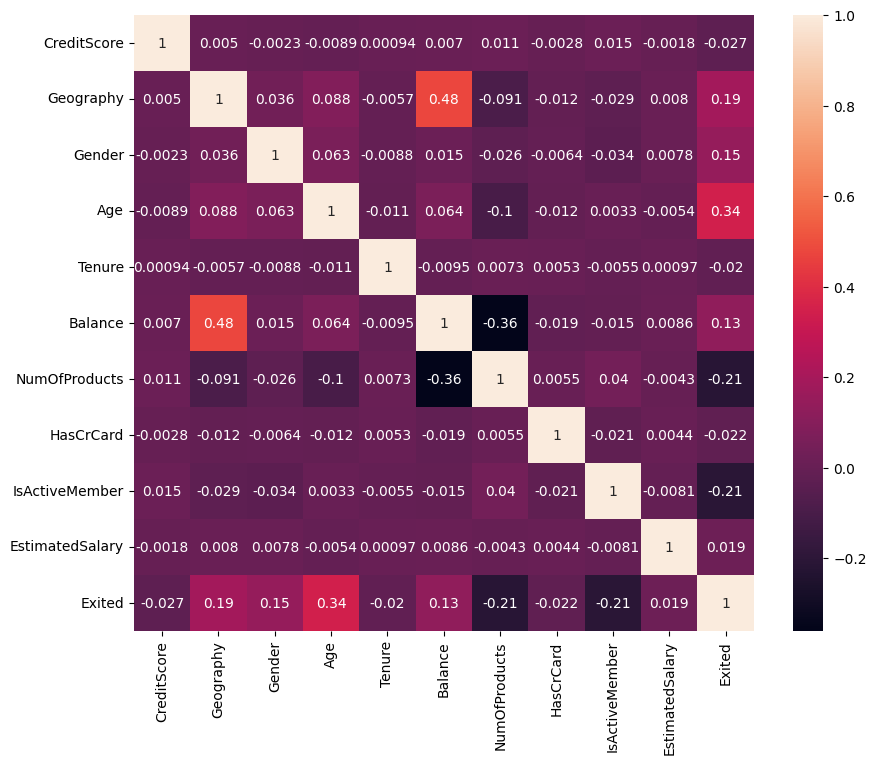

In [99]:
heatmapData = df.drop(['Surname', 'id', 'CustomerId'], axis=1)
heatmapData['Gender'] = heatmapData['Gender'].map({'Male': 0, 'Female': 1})
heatmapData['Geography'] = heatmapData['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
plt.figure(figsize=(10,8))
sns.heatmap(heatmapData.corr(), annot=True)
plt.show()

In [141]:
df = pd.read_csv("data/train.csv")

df['AgeBin']=pd.cut(df['Age'],5)
df['BalanceBin']=pd.cut(df['Balance'],5)
df['CreditScoreBin']=pd.cut(df['CreditScore'],5)
df['EstimatedSalaryBin']=pd.cut(df['EstimatedSalary'],5)

df[['AgeBin','Exited']].groupby(['AgeBin'],as_index=False).mean().sort_values(by='AgeBin',ascending=True)
df[['BalanceBin','Exited']].groupby(['BalanceBin'],as_index=False).mean().sort_values(by='BalanceBin',ascending=True)
df[['EstimatedSalaryBin','Exited']].groupby(['EstimatedSalaryBin'],as_index=False).mean().sort_values(by='EstimatedSalaryBin',ascending=True)
df[['CreditScoreBin','Exited']].groupby(['CreditScoreBin'],as_index=False).mean().sort_values(by='CreditScoreBin',ascending=True)

/var/folders/zs/5d7ptdmj0cg4xl426n5xdzt00000gn/T/ipykernel_37274/3664194744.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['AgeBin','Exited']].groupby(['AgeBin'],as_index=False).mean().sort_values(by='AgeBin',ascending=True)
/var/folders/zs/5d7ptdmj0cg4xl426n5xdzt00000gn/T/ipykernel_37274/3664194744.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['BalanceBin','Exited']].groupby(['BalanceBin'],as_index=False).mean().sort_values(by='BalanceBin',ascending=True)
/var/folders/zs/5d7ptdmj0cg4xl426n5xdzt00000gn/T/ipykernel_37274/3664194744.py:10: FutureWarning: The default of observed=False is depre

,CreditScoreBin,Exited
0,"(349.5, 450.0]",0.237792
1,"(450.0, 550.0]",0.241789
2,"(550.0, 650.0]",0.223080
3,"(650.0, 750.0]",0.197355
4,"(750.0, 850.0]",0.203773


In [142]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
df['AgeCode']=le.fit_transform(df['AgeBin'])
df['BalanceCode']=le.fit_transform(df['BalanceBin'])
df['CreditScoreCode']=le.fit_transform(df['CreditScoreBin'])
df['EstimatedSalaryCode']=le.fit_transform(df['EstimatedSalaryBin'])

df.drop(['AgeBin','BalanceBin','CreditScoreBin','EstimatedSalaryBin','CreditScore','Age','Balance','EstimatedSalary'], inplace=True, axis=1)

In [143]:
X = df.drop(['Surname', 'id', 'CustomerId', 'Exited'], axis=1)

X['Gender'] = X['Gender'].map({'Male': 0, 'Female': 1})
X['Geography'] = X['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
X.fillna(0, inplace=True)

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(df['Exited'].values, dtype=torch.float32)

#STANDARDIZATION (Disable later and check how it affects accuracy)
X = (X - torch.mean(X, dim=0)) / torch.std(X, dim=0)

# Network

In [137]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # self.featureWeights = featureWeights

        # self.weights = nn.Parameter(torch.tensor(featureWeights, dtype=torch.float32))
        self.layer1 = nn.Linear(10, 64)
        self.act1 = nn.LeakyReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.act2 = nn.LeakyReLU()
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 1)
        self.act3 = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = x * self.weights
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        x = self.act3(self.layer3(x))
        x = self.sigmoid(x)
        x = self.dropout(x)
        return x

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)

RandomForestClassifier()

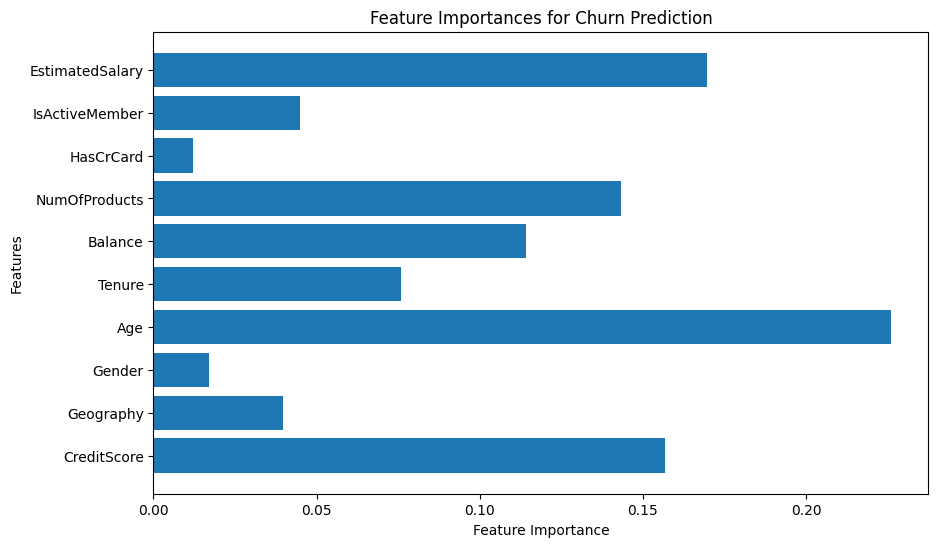

In [6]:
import matplotlib.pyplot as plt

feature_importances = rf_classifier.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary'], feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Churn Prediction')
plt.show()

In [138]:
import torch.optim as optim

model = Classifier().to("mps")
lossFN = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.7965, Accuracy: 0.3810
Epoch [2/10], Loss: 0.7794, Accuracy: 0.7619
Epoch [3/10], Loss: 0.6791, Accuracy: 0.8810
Epoch [4/10], Loss: 0.7097, Accuracy: 0.8095
Epoch [5/10], Loss: 0.7091, Accuracy: 0.7143
Epoch [6/10], Loss: 0.6825, Accuracy: 0.8810
Epoch [7/10], Loss: 0.7003, Accuracy: 0.7143
Epoch [8/10], Loss: 0.6550, Accuracy: 0.8810
Epoch [9/10], Loss: 0.7006, Accuracy: 0.8571
Epoch [10/10], Loss: 0.6667, Accuracy: 0.9524
Completed training in  125.93574905395508 s


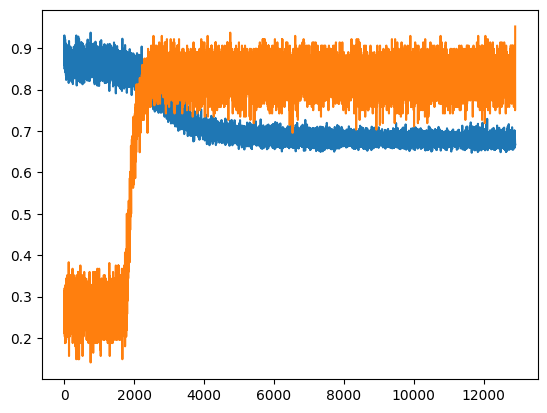

In [139]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time


X = X.to("mps")
y = y.to("mps")
dataset = TensorDataset(X, y)
dataLoader = DataLoader(dataset, batch_size=128, shuffle=True)

losses = []
accuracies = []
NUM_EPOCHS = 10

startTime = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, labels in dataLoader:
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted_probabilities = outputs.squeeze(1)  # Remove the singleton dimension
        predicted_labels = (predicted_probabilities >= 0.5).float()  # Convert probabilities to binary predictions
        accuracy = (predicted_labels == labels).float().mean()
        
        loss = lossFN(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

print("Completed training in ", time.time() - startTime, "s")
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [150]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X,y)


In [151]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_resampled, y_resampled, cv=10, scoring="accuracy")
scores.mean()

0.8504838618886925

In [154]:
rfModel = rf.fit(X_resampled, y_resampled)

In [153]:
rfModel.predict(X_)

RandomForestClassifier()

In [15]:
#Checking the model
model.eval()
output = model(X[35:45])

predicts = torch.round(output.squeeze(1) * 10) / 10

output.data.squeeze(1)

tensor([3.9282e-04, 2.9966e-03, 9.1825e-04, 2.8870e-04, 1.0000e+00, 8.4607e-04,
        9.5117e-04, 1.0000e+00, 9.0478e-04, 6.6145e-04], device='mps:0')

In [16]:
#Test Set
testData = pd.read_csv("data/test.csv")

y_test = testData['id']
testData.drop(['Surname', 'id', 'CustomerId'], axis=1, inplace=True)
testData['Gender'] = trainingData['Gender'].map({'Male': 0, 'Female': 1})
testData['Geography'] = trainingData['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
testData.fillna(0, inplace=True)

In [51]:
y_test.values

array([165034, 165035, 165036, ..., 275054, 275055, 275056])

In [55]:
X

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,0,0,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,0,0,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,0,0,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,0,0,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,1,0,33.0,5,0.00,2,1.0,1.0,15068.83
...,...,...,...,...,...,...,...,...,...,...
165029,667,1,1,33.0,2,0.00,1,1.0,1.0,131834.75
165030,792,0,0,35.0,3,0.00,1,0.0,0.0,131834.45
165031,565,0,0,31.0,5,0.00,1,1.0,1.0,127429.56
165032,554,1,1,30.0,7,161533.00,1,0.0,1.0,71173.03


In [44]:
X_test = testData.values
X_test = torch.tensor(X_test, dtype=torch.float32)
#STANDARDIZATION (Disable later and check how it affects accuracy)
epsilon = 1e-12  # small value to avoid division by zero
X_test = (X_test - torch.mean(X_test, dim=0)) / (torch.std(X_test, dim=0) + epsilon)
X_test = X_test.to("mps")

In [45]:
X_test[0:5]

tensor([[-0.8782,  0.0000,  0.0000, -1.7065, -1.0679, -0.8813,  0.8200, -1.7462,
          1.0096,  0.9679],
        [ 0.3296,  0.0000,  0.0000,  0.8890, -1.0679, -0.8813, -1.0158,  0.5727,
         -0.9905, -0.7909],
        [-0.0066,  0.0000,  0.0000, -0.4652,  0.7139, -0.8813,  0.8200,  0.5727,
         -0.9905,  0.5284],
        [ 0.3047,  0.0000,  0.0000, -0.2395,  1.0703, -0.8813, -1.0158,  0.5727,
         -0.9905,  0.0322],
        [ 1.1887,  0.0000,  0.0000, -0.0138,  1.7830,  1.0500, -1.0158,  0.5727,
         -0.9905,  0.5393]], device='mps:0')

In [47]:
predictions = []
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    predicted = torch.round(outputs.squeeze(1) * 10) / 10
    predictions.extend(predicted.cpu().numpy())

In [52]:
predictionsDF = pd.DataFrame({'id': y_test.values, 'Exited': predictions})

In [53]:
predictionsDF.to_csv('predictions.csv', index=False)